In [1]:
import pandas as pd
import numpy as np
import requests

In [2]:
def get_data(token):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )
    if res.json().get('error',0)!=0:
        res = requests.get(
        f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )
    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df


In [3]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']
dfs = [get_data(token) for token in tokens]

In [4]:
df_base = pd.concat(dfs[i] for i in range(len(dfs)))

In [5]:
df_base.groupby('token')['volumeUSD'].sum().to_frame().sort_values(by = 'volumeUSD', ascending = False)

,volumeUSD
token,
ETH,2.112992e+10
SOL,6.910334e+09
AVAX,3.429380e+09
USDT,1.977090e+09
FLOW,8.684241e+07


In [6]:
df_ans2 = pd.concat([df_base[df_base['token']=='ETH']['close'],df_base[df_base['token']=='SOL']['close']], axis=1)

In [7]:
df_ans2.columns = ['ETH_close', 'SOL_close']
df_ans2['ratio'] = df_ans2['ETH_close']/df_ans2['SOL_close']
df_ans2

,ETH_close,SOL_close,ratio
0,4262.99,230.785,18.471694
1,4234.37,226.000,18.736150
2,4217.89,227.037,18.577985
3,4193.47,223.117,18.794937
4,4168.35,220.652,18.891059
...,...,...,...
537,3818.17,156.960,24.325752
538,3767.65,153.500,24.544951
539,3818.31,155.670,24.528233
540,3840.61,158.180,24.279997


In [8]:
df_base.rename(
    columns={
        'volume':'volumeBase',
        'volumeUSD':'volumeTerm'
    }
)

,ts,open,high,low,close,volumeBase,volumeTerm,token
0,2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH
...,...,...,...,...,...,...,...,...
537,2021-12-14 09:00:00,8.331,8.366,8.275,8.351,14178.227716,1.177864e+05,FLOW
538,2021-12-14 10:00:00,8.341,8.341,8.200,8.200,32822.467705,2.709334e+05,FLOW
539,2021-12-14 11:00:00,8.226,8.362,8.219,8.362,3990.171002,3.297432e+04,FLOW
540,2021-12-14 12:00:00,8.355,8.536,8.339,8.536,15920.985638,1.346306e+05,FLOW


In [9]:
da = df_base.reset_index().pivot('ts','token','close')

In [10]:
for col in da.columns:
    da[col] = np.log(da[col] / da[col].shift(1))

In [11]:
da = da.drop(pd.to_datetime('2021-11-22 00:00:00'))

In [12]:
da

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 01:00:00,0.046912,-0.006736,-0.038102,-0.020952,0.0001
2021-11-22 02:00:00,-0.017279,-0.003900,0.009644,0.004578,-0.0001
2021-11-22 03:00:00,0.006318,-0.005806,-0.007371,-0.017417,-0.0001
2021-11-22 04:00:00,0.021583,-0.006008,-0.005214,-0.011109,-0.0002
2021-11-22 05:00:00,-0.031832,-0.002472,-0.014014,-0.015161,-0.0001
...,...,...,...,...,...
2021-12-14 09:00:00,0.015030,0.008889,0.004200,0.013728,0.0001
2021-12-14 10:00:00,-0.020218,-0.013320,-0.018247,-0.022290,0.0000
2021-12-14 11:00:00,0.014358,0.013356,0.019563,0.014038,0.0000


In [13]:
da_corr = da.corr()

In [14]:
da_corr

token,AVAX,ETH,FLOW,SOL,USDT
token,,,,,
AVAX,1.000000,0.646566,0.389744,0.626640,-0.018638
ETH,0.646566,1.000000,0.564340,0.740875,-0.120073
FLOW,0.389744,0.564340,1.000000,0.450166,-0.193048
SOL,0.626640,0.740875,0.450166,1.000000,0.104046
USDT,-0.018638,-0.120073,-0.193048,0.104046,1.000000


In [15]:
import seaborn as sns

<AxesSubplot:xlabel='token', ylabel='token'>

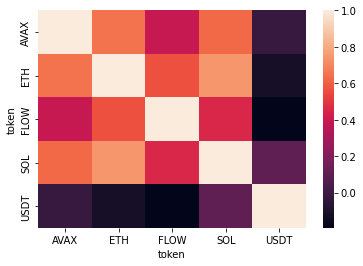

In [16]:
sns.heatmap(da_corr)